[![logo](https://climate.copernicus.eu/sites/default/files/custom-uploads/branding/LogoLine_horizon_C3S.png)](https://climate.copernicus.eu)

# Custom spatial aggregation of CF data: an SPV example

This notebook aims to provide an overview on how Transmission System Operators (TSOs) can implement customized spatial aggregations within the Pan-European Climate Database version 4.2 ([PECD4.2](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=overview)) data, in particular one weighted by the installed capacity (IC) of a given technology.

SPV is used here as an example, since the default aggregation done for this technology follows a simplistic assumption. Thus, this tutorial will help to clarify this, as well provide TSOs with the means and know-how on how to handle this.

In this example, we will download and read aggregated NUTS2 data in CSV format for utility-scale fixed PV in 2020 / historical stream and use France as a case study.

## Learning objectives 🧠

In this notebook, you will learn on **how to generate NUTS0 data using finer NUTS2 data and a IC-based weighting**. You will also understand the way SPV data in the PECD is aggregated and its limitations.

## Target Audience 🎯

**Anyone** interested in custom spatial aggregation of solar generation capacity factors from PECD 4.2 using CSV data and region-based weighting.

## Prepare your environment

### Import libraries

In the following we will import six libraries: the [os](https://docs.python.org/3/library/os.html) module provides functions to interact with the operating system, especially for file and directory operations. It allows the script to build portable file paths, list contents of folders, or check if files exist. The [pandas](https://pandas.pydata.org/docs/) module provides a way to read, handle, and visualize tabular data; the [numpy](https://numpy.org/doc/stable) module is here used to generate sequence of float values; and the [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module allows us to generate and edit standard visualizations, whereas [geopandas](https://geopandas.org/en/stable/) excels in spatial data editing and plotting. [cdsapi](https://github.com/ecmwf/cdsapi?tab=readme-ov-file) is a Python library that provides programmatic access to the Copernicus Climate Data Store (CDS), allowing you to download the relevant data for this work.

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cdsapi

### Set up the CDS API and your credentials

This step is essential to be able to download the data. To learn how to use the CDS API, see the [official guide](https://cds.climate.copernicus.eu/how-to-api). If you have already set up your .cdsapirc file locally, you can upload it directly to your home directory.

Alternatively, you can replace None in the following code cell with your API Token as a string (i.e. enclosed in quotes, like ```"your_api_key"```). Your token can be found on the CDS portal at: https://cds.climate.copernicus.eu/profile (you will need to log in to view your credentials).
Remember to agree to the Terms and Conditions of every dataset you intend to download.

In [ ]:
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = "https://cds.climate.copernicus.eu/api"

## Download the data

The data can be downloaded from the PECD CDS download form, by ticking the boxes of interest. Once all the required information is manually selected, scroll to the bottom of the form and click on "Show API request". This will reveal a code block that can be copied and pasted directly into a cell of your Jupyter Notebook. This step has already been done for you in the cell below, but if you'd like to try it yourself, visit the [CDS download form](https://cds.climate.copernicus.eu/datasets/sis-energy-pecd?tab=download).

In this example, we use data from PECD version “PECD4.2” for the “Historical” temporal stream, derived from ERA5 reanalysis. The selected variable is the “solar photovoltaic generation capacity factor”, retrieved for the year 2020 at "NUTS2" spatial resolution and covering the photovoltaic technology "62 (SPV utility-scale fixed)", i.e. large, ground-based installations with fixed Si modules.

The API request reflecting these selections is shown in the next cell.

In [49]:
# Historical ERA5 – solar PV capacity factor for 2020, four technologies at NUTS-2
dataset = "sis-energy-pecd"
request = {
    "pecd_version": "pecd4_2",
    "temporal_period": ["historical"],
    "origin": ["era5_reanalysis"],
    "year": ["2020"],
    "variable": ["solar_photovoltaic_generation_capacity_factor"],
    "technology": ["62"],
    "spatial_resolution": ["nuts_2"],
}

Before running the download we can make sure there is a dedicated folder ready to host the data.

In [42]:
input_dir = "cds_data/custom_spatial_aggregation/"
os.system(f"mkdir -p {input_dir}")

0

Now that it is all set, we are ready to download the data.

In [ ]:
# initialize Client object
client = cdsapi.Client(cdsapi_url, cdsapi_key)
# call the retrieve method that downloads data
client.retrieve(dataset, request, f"{input_dir}/data.zip")

Since our data are inside zipped files we need to unzip them. The final CSV file will have a name according to the naming conventions of Pan-European Climate Database. You can find the explanation of the different fields in the [production guide](https://confluence.ecmwf.int/pages/viewpage.action?pageId=439598955#ClimateandenergyrelatedvariablesfromthePanEuropeanClimateDatabasederivedfromreanalysisandclimateprojections:Productuserguide(PUG)-Filenamesconventionandcharacteristics) of the PECD.

In [ ]:
# Unzipping every file in our folder
for fname in os.listdir(input_dir):
    if fname.endswith(".zip"):
        os.system(f"unzip {input_dir}/{fname} -d {input_dir}")

Archive:  cds_data/custom_spatial_aggregation//data.zip
  inflating: cds_data/custom_spatial_aggregation/H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_S202001010000_E202012312300_CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv  


### Read data

In [43]:
# spv_utility_fix, 2020 (as an example)
filename = (
    "H_ERA5_ECMW_T639_SPV_0000m_Pecd_NUT2_S202001010000_E202012312300_"
    "CFR_TIM_01h_COM_noc_org_62_NA---_NA---_PhM03_PECD4.2_fv1.csv"
)

df = pd.read_csv(
    input_dir + filename, comment="#", delimiter=",", index_col=["Date"], parse_dates=["Date"]
)
df.iloc[:9, 10:15]

,AT11,AT12,AT13,AT21,AT22
Date,,,,,
2020-01-01 00:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 01:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 02:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 03:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 04:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 05:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 06:00:00,0.00000,0.00000,0.0000,0.00000,0.00000
2020-01-01 07:00:00,0.00002,0.00000,0.0000,0.00000,0.00000
2020-01-01 08:00:00,0.07616,0.04995,0.0498,0.08675,0.07835


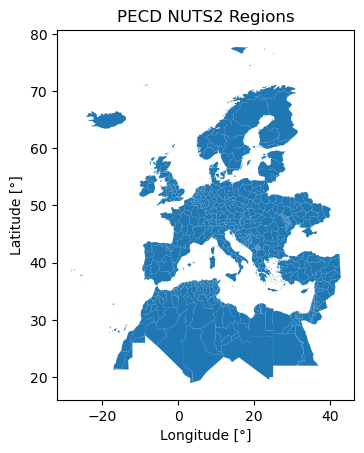

In [45]:
# Reading polygon describing PECD NUTS2 regions
shp_dir = "shape_files/custom_spatial_aggregation/"
shp = "NUT2_ADM1_PECD_fixed.shp"
gdf = gpd.read_file(shp_dir + shp)
gdf = gdf.rename(columns={"PECD_CODE": "NUTS2"})

ax = gdf.plot()

ax.set_title("PECD NUTS2 Regions")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

## On spatial aggregation within the PECD 

### An overview


**Both solar resource and PV deployment can be characterized by spatial patterns**. For example, latitudes closer to the equator are characterized by a more abundant solar resource. And, at the same time, it is possible - but not necessarily true - that SPV deployment favors sunnier regions in order to achieve higher capacity factor values. Thus, **when aggregating the gridded data, the weighting of each region should reflect this**.

That would be the case for **France, for example, where PV deployment is strongly influenced by the quality of the solar resource available**.

### Continental France as an example

#### Filtering data

                     FR10  FRB0  FRC1  FRC2  FRD1
Date                                             
2020-01-01 00:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 01:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 02:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 03:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 04:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 05:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 06:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 07:00:00  0.00  0.00  0.00  0.00   0.0
2020-01-01 08:00:00  0.00  0.00  0.00  0.01   0.0
2020-01-01 09:00:00  0.01  0.01  0.06  0.14   0.0




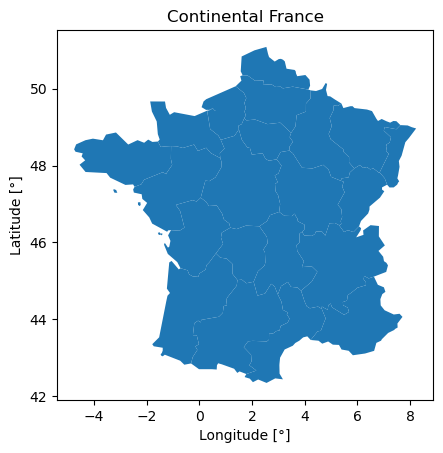

In [30]:
# Filtering PECD data
region_ix = [(arr[0:2] == "FR") & (arr != "FRM0") for arr in df.columns.values]
df2 = df.loc[:, region_ix]
print(df2.iloc[:10, :5].round(2))

# prints blank line
print("\n")

# Filtering continental France
region_bool = [(arr[0:2] == "FR") & (arr != "FRM0") for arr in gdf.NUTS2.values]
gdf2 = gdf.loc[region_bool, :].set_index("NUTS2")
ax = gdf2.plot()

ax.set_title("Continental France")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

#### NUTS2-level IC data, the spatial weights

RTE, **the French TSO, provided us with an example dataset from a given year with the fraction of PV installed capacity for projects >1 MW** (i.e. utility-scale, being in France mostly the fixed type).

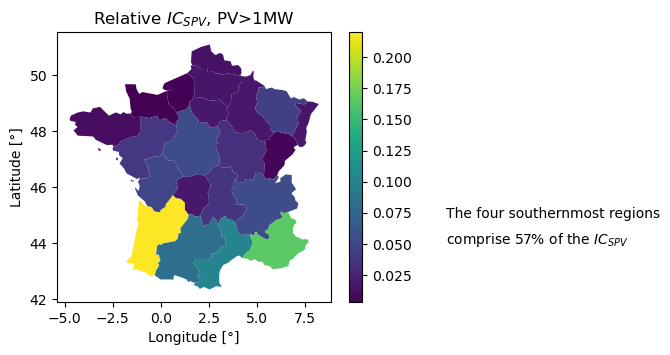

In [31]:
# RTE data for NUTS2 capacity relative weights (sum=1)
cap_weights = {
    "FR10": 0.017276,
    "FRB0": 0.053080,
    "FRC1": 0.032795,
    "FRC2": 0.006959,
    "FRD1": 0.003723,
    "FRD2": 0.005285,
    "FRE1": 0.013182,
    "FRE2": 0.015625,
    "FRF1": 0.016401,
    "FRF2": 0.016972,
    "FRF3": 0.043588,
    "FRG0": 0.038056,
    "FRH0": 0.011099,
    "FRI1": 0.219946,
    "FRI2": 0.018033,
    "FRI3": 0.049504,
    "FRJ1": 0.101388,
    "FRJ2": 0.081466,
    "FRK1": 0.037489,
    "FRK2": 0.053358,
    "FRL0": 0.164773,
}

df0 = pd.DataFrame.from_dict(cap_weights, orient="index", columns=["Weight"])

# add it to the geospatial dataframe that contained the polygons
gdf3 = pd.concat([gdf2, df0], axis=1)

# visualize it
ax = gdf3.plot(column="Weight", legend=True, figsize=(4.5, 3.5))
ax.set_title("Relative $IC_{SPV}$, PV>1MW")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")

val = (df0.sort_values(by="Weight").iloc[-4:].values.sum() * 100).round(0).astype(int)

textstr = ["The four southernmost regions", "comprise {}% of the $IC_{}$".format(val, "{SPV}")]
for k in range(0, 2):
    plt.text(1, 0.35 - k * 0.075, textstr[k], transform=plt.gcf().transFigure)

plt.show()

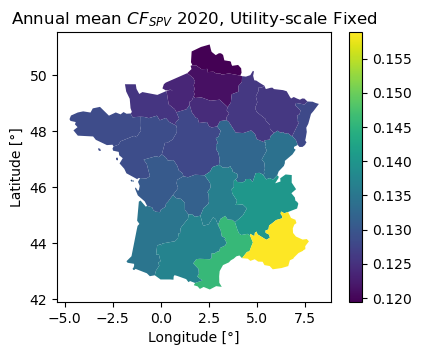

In [32]:
# append as well NUTS2 annual mean CF (2020)
gdf4 = pd.concat([gdf3, pd.DataFrame(df2.mean(), columns=["CF"])], axis=1)

ax = gdf4.plot(column="CF", legend=True, figsize=(4.5, 3.5))
ax.set_title("Annual mean $CF_{SPV}$ 2020, Utility-scale Fixed")
ax.set_xlabel("Longitude [°]")
ax.set_ylabel("Latitude [°]")
plt.show()

### Spatial aggregation


Ideally, spatial aggregation of the PECD gridded data would consider how the IC of a given technology is distributed in space.

But since **there is no easily available IC data with sub-national resolution covering the whole PECD region, the implemented workflow had to follow the naive assumption that PV is homogeneously distributed** (although ignoring exclusion areas).

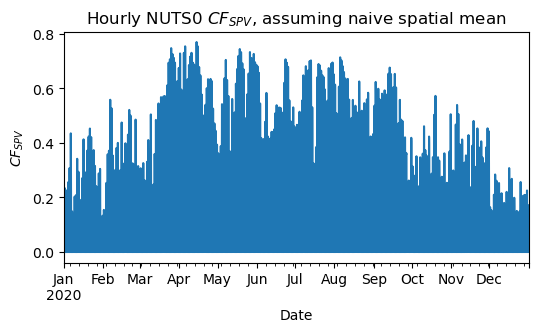

In [33]:
# Naive spatial mean (assumes PV is equally present in every NUTS2 region)
ax = df2.mean(axis=1).plot(figsize=(6, 3))
ax.set_title("Hourly NUTS0 $CF_{SPV}$, assuming naive spatial mean")
ax.set_ylabel("$CF_{SPV}$")
plt.show()

However, **in a case like France, this naive assumption is likely to underestimate the actual aggregated capacity factor** values, since it gives the same importante to less sunnier regions where there is less PV installed. 

### NUTS2 and IC-based aggregation

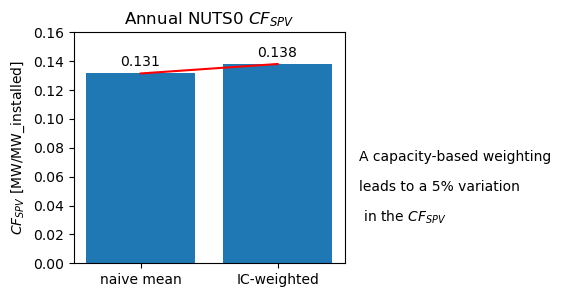

In [34]:
annual_means = [
    df2.mean(axis=1).values.mean(),  # naive spatial mean
    (df2 * df0.squeeze()).sum(axis=1).values.mean(),  # IC-weighted spatial mean
]

delta = ((annual_means[1] / annual_means[0] - 1) * 100).round(0).astype(int)

# Labels
labels = ["naive mean", "IC-weighted"]

# Plot
plt.figure(figsize=(3.5, 3))
plt.bar(labels, annual_means)
plt.plot([0, 1], annual_means, color="r")
plt.ylim([0, 0.16])
plt.title("Annual NUTS0 $CF_{SPV}$")
plt.ylabel("$CF_{SPV}$ [MW/MW_installed]")
plt.text(0 - 0.15, annual_means[0] + 0.005, annual_means[0].round(3))
plt.text(1 - 0.15, annual_means[1] + 0.005, annual_means[1].round(3))

textstr = [
    "A capacity-based weighting",
    "leads to a {}% variation".format(delta),
    " in the $CF_{}$".format("{SPV}"),
]
for k in range(0, 3):
    plt.text(0.94, 0.45 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

plt.show()
plt.close()

#### A seasonal perspective

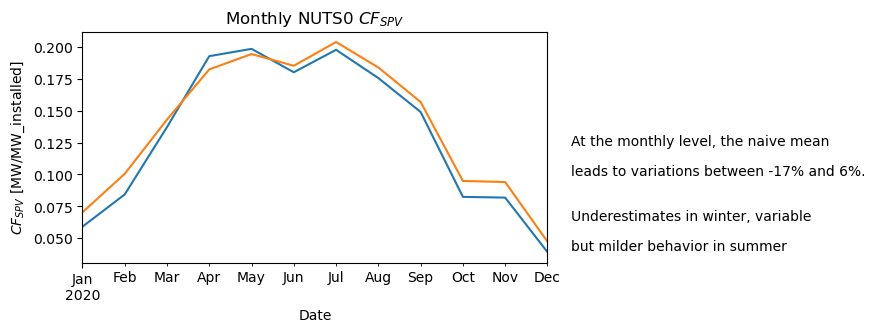

In [35]:
# computes monthly means
a = df2.mean(axis=1).groupby(pd.Grouper(freq="1ME")).mean()  # naive mean
b = (df2 * (df0.squeeze())).sum(axis=1).groupby(pd.Grouper(freq="1ME")).mean()  # IC-weighted mean

# plots monthly means
a.plot(figsize=(6, 3))
b.plot()
plt.title("Monthly NUTS0 $CF_{SPV}$")
plt.ylabel("$CF_{SPV}$ [MW/MW_installed]")

# min and max monthly relative deviations
range_ = (np.array([min(a / b - 1), max(a / b - 1)]) * 100).round(0).astype(int)

textstr = [
    "At the monthly level, the naive mean",
    f"leads to variations between {range_[0]}% and {range_[1]}%.",
]
for k in range(0, 2):
    plt.text(0.94, 0.5 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

textstr = ["Underestimates in winter, variable", "but milder behavior in summer"]
for k in range(0, 2):
    plt.text(0.94, 0.25 - k * 0.1, textstr[k], transform=plt.gcf().transFigure)

plt.show()

> **Additional note**:
> 
> While in France this does not seem to be the case, **different typologies can have different spatial patterns**. This can be driven by spatial variations in solar resource availability, land use, population and industry density, as well as regulatory/business practices.
>
> For example, in Portugal, self-consumption is more present near the coastline where people/services are, and in the North where there is more industry.

## Take home messages 📌


*   As no sub-national IC data for SPV is available for the whole PECD region, **gridded data is currently aggregated using a naive spatial mean** that assumes that SPV is equally present within a given territory (dismissing certain exclusion areas).
*   **When suitable IC data is available, it is easy to account for** a custom spatial weighting relying for example on the NUTS2 aggregated data. A similar approach could be used for the raw gridded data, but unless data finer than NUTS2 is available, it would lead to the same result while requiring the reading and processing of NetCDF files.
*   **A custom aggregation was done for France**, as an example, where PV prevails in the sunnier South. In this case, while it raises the annual CF, at the seasonal level the custom aggregation can both increase and decrease the CF values.
*   These results depend on the spatial patterns of both IC and CF.
*   **For SPV the IC spatial patterns can vary considerably from one country to another**, which asks for a broader data collection.